# Reduce out-of-service energy:

* Which equipment/trains have an "anomalous" consumption?

In [1]:
# Importing necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
df = pd.read_csv('data/clean_clean_energy.csv')

In [4]:
# Filter out records where tiempo_parada is 0
df = df[df['tiempo_parada'] != 0]

df['net_energy_consumed_by_UT_km'] = df['net_energy_consumed_by_UT']/df['kilometres']

# Focus on the net energy consumed by UT
energy_column = 'net_energy_consumed_by_UT_km'

# Group by client line and UT to calculate average net energy consumed
energy_avg = df.groupby(['client_line', 'ut'])[energy_column].mean().reset_index()

# Function to apply Isolation Forest within each client line
def detect_anomalies(group):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(group[[energy_column]])
    
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    group['anomaly_score'] = iso_forest.fit_predict(scaled_data)
    group['anomaly'] = group['anomaly_score'].map({1: 0, -1: 1})
    return group

# Apply the anomaly detection for each client line
anomaly_results = energy_avg.groupby('client_line').apply(detect_anomalies)

# Identify anomalies
anomalies = anomaly_results[anomaly_results['anomaly'] == 1]

print("Anomalous UTs:")
anomalies[['client_line', 'ut', energy_column]]

Anomalous UTs:


client_line   ut  \
client_line                                                 
Bilbao-Donostia         17           Bilbao-Donostia  918   
                        18           Bilbao-Donostia  919   
Donostia-Hendaia        43          Donostia-Hendaia  914   
                        47          Donostia-Hendaia  918   
L3 Txori                64                  L3 Txori  905   
                        85                  L3 Txori  926   
Ramal Amorebieta-Bermeo 98   Ramal Amorebieta-Bermeo  910   
                        114  Ramal Amorebieta-Bermeo  926   
Ramal Lasarte           141            Ramal Lasarte  923   
                        144            Ramal Lasarte  926   

                             net_energy_consumed_by_UT_km  
client_line                                                
Bilbao-Donostia         17                       5.391751  
                        18                       5.446260  
Donostia-Hendaia        43                       5.274985  
                        47                       6.053670  
L3 Txori                64                       2.230816  
                        85                       3.802626  
Ramal Amorebieta-Bermeo 98                       4.422682  
                        114                      7.238232  
Ramal Lasarte           141                     10.540682  
                        144                     10.525208

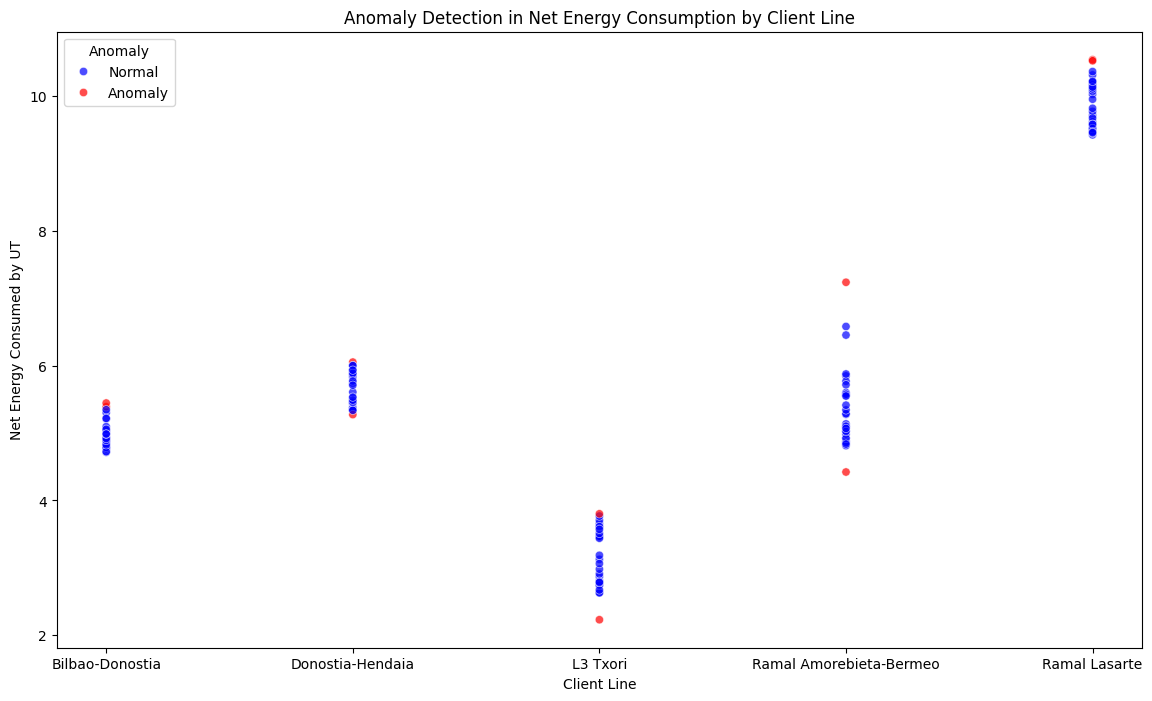

In [5]:
# Plotting anomalies for each client line
plt.figure(figsize=(14, 8))

# Plot normal and anomalous points
scatter_plot = sns.scatterplot(data=anomaly_results, x='client_line', y=energy_column, hue='anomaly', palette={0: 'blue', 1: 'red'}, alpha=0.7)

# Create custom legend
handles, labels = scatter_plot.get_legend_handles_labels()

# Ensure the correct labels for the handles
new_handles = []
new_labels = []
for handle, label in zip(handles, labels):
    if label == '0':
        new_handles.append(handle)
        new_labels.append('Normal')
    elif label == '1':
        new_handles.append(handle)
        new_labels.append('Anomaly')

# Set the custom legend
scatter_plot.legend(handles=new_handles, labels=new_labels, title='Anomaly', loc='best')

plt.title('Anomaly Detection in Net Energy Consumption by Client Line')
plt.xlabel('Client Line')
plt.ylabel('Net Energy Consumed by UT')
plt.show()

In [6]:
# Group by UT to calculate average net energy consumed
energy_avg = df.groupby('ut')[energy_column].mean().reset_index()

# Standardize the net energy consumed
scaler = StandardScaler()
scaled_data = scaler.fit_transform(energy_avg[[energy_column]])

# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
energy_avg['anomaly_score'] = iso_forest.fit_predict(scaled_data)
energy_avg['anomaly'] = energy_avg['anomaly_score'].map({1: 0, -1: 1})

# Identify anomalies
anomalies = energy_avg[energy_avg['anomaly'] == 1]

print("Anomalous UTs:")
anomalies[['ut', energy_column]]

Anomalous UTs:


,ut,net_energy_consumed_by_UT_km
17,918,6.020791
24,925,5.086786


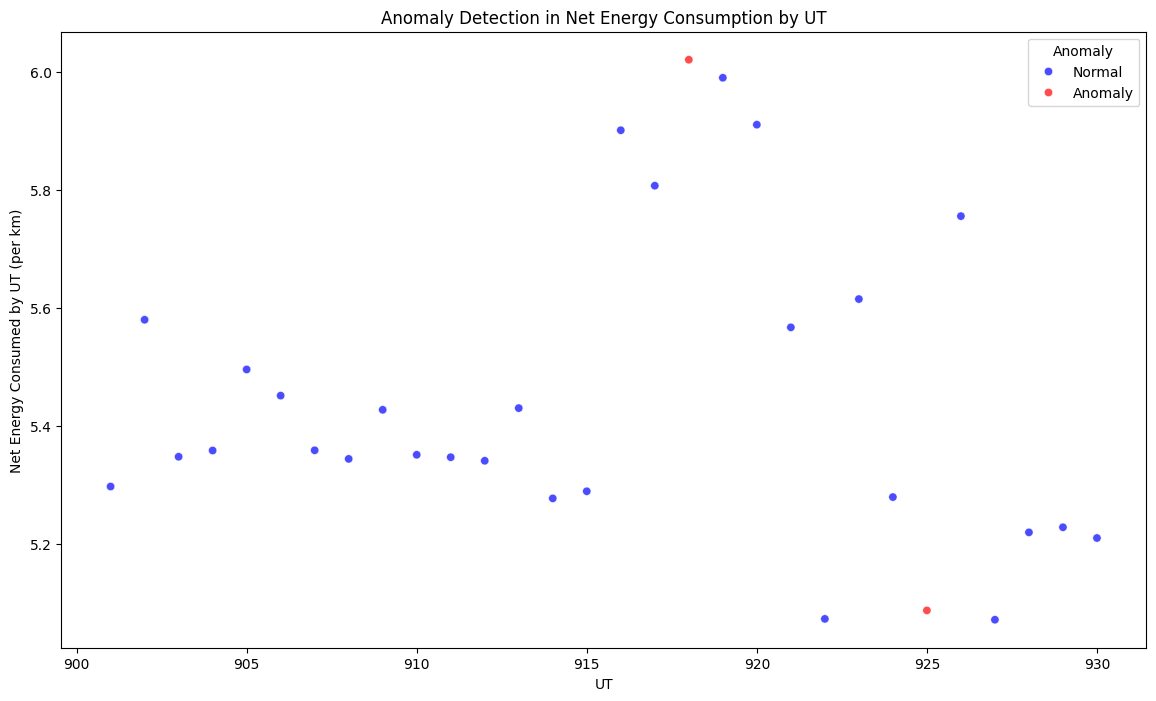

In [7]:
# Plotting anomalies
plt.figure(figsize=(14, 8))

# Plot normal and anomalous points
scatter_plot = sns.scatterplot(data=energy_avg, x='ut', y=energy_column, hue='anomaly', palette={0: 'blue', 1: 'red'}, alpha=0.7)

# Create custom legend
handles, labels = scatter_plot.get_legend_handles_labels()

# Ensure the correct labels for the handles
new_handles = []
new_labels = []
for handle, label in zip(handles, labels):
    if label == '0':
        new_handles.append(handle)
        new_labels.append('Normal')
    elif label == '1':
        new_handles.append(handle)
        new_labels.append('Anomaly')

# Set the custom legend
scatter_plot.legend(handles=new_handles, labels=new_labels, title='Anomaly', loc='best')

plt.title('Anomaly Detection in Net Energy Consumption by UT')
plt.xlabel('UT')
plt.ylabel('Net Energy Consumed by UT (per km)')
plt.show()

From this analysis, we were able to identify 918, and 925 as outliers. 